# **RSNA 2021: Deep Learning Lab**

## **Basics of Information Extraction from Radiology Reports**

In this demonstration, we will utilize techniques of _natural language processing_ (NLP) to train a classifier, which will analyze the text of radiology reports for chest radiographs to predict whether a report is **normal** or **abnormal**.

### Code
We will utilize the [fast.ai v2 library](https://docs.fast.ai/), written primarily by Jeremy Howard and Sylvain Gugger (with help from many others). It is written in the [Python programming language](https://www.python.org/) and built on top of the [PyTorch deep learning library](https://www.pytorch.org/).

The demonstration in this notebook relies heavily on examples from the `fast.ai` book, _Deep Learning for Coders with fastai and PyTorch: AI Applications without a PhD_ by Jeremy Howard and Sylvain Gugger, which was written entirely in Jupyter notebooks, which are [freely available for download on GitHub](https://github.com/fastai/fastbook). A print copy of the book can be purchased from Amazon.

### Data

The data is obtained from the National Library of Medicine's Open-i service. We utilize the radiology reports from the [Indiana University Chest X-ray Dataset](https://openi.nlm.nih.gov/faq#collection) for this demonstration.

> _Reference:_ Demner-Fushman D, Kohli MD, Rosenman MB, Shooshan SE, Rodriguez L, Antani S, Thoma GR, McDonald CJ. Preparing a collection of radiology examinations for distribution and retrieval. J Am Med Inform Assoc. 2016 Mar;23(2):304-10. doi: 10.1093/jamia/ocv080. Epub 2015 Jul 1.

### Developers
- Walter F. Wiggins, MD, PhD - Duke University Hospital, Durham, NC, USA
- Felipe Kitamura, MD - UNIFESP, Sao Paulo, Brasil
- Igor Santos, MD - UNIFESP, Sao Paulo, Brasil
- Luciano M. Prevedello, MD, MPH - Ohio State University, Columbus, OH, USA

## Interactive Participation

This notebook is designed for interactive participation. 

If you are running this notebook on your own machine, you may download the notebook with this link: [Download notebook](/notebooks/RNNs_tutorial.ipynb).

Please refer to the previous posts on [installing Python](/posts/install-python.qmd) and [installing PyTorch and fast.ai](/posts/install-pytorch.qmd) with `uv` to ensure your environment is set up properly. You'll also need to run the following commands to add two additional packages to your `uv` project.

```sh
uv add xmltodict
uv add tensorboard
```

You can run the code cells in order, and modify parameters as desired to see how they affect the results.

If you are using Google Colab, please use the link below to open a compatible version in Colab. You can save a copy of the notebook to your own Google Drive by selecting "File" -> "Save a copy in Drive".

[Open in Colab](https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab-2023/blob/main/sessions/nlp-text-classification/RSNA21_RNNs_with_Tensorboard.ipynb)

# Downloading the Data

When you run the following cell, the [NLM Open-i "Indiana University Chest X-ray Reports" dataset](https://openi.nlm.nih.gov/faq#collection) will be downloaded.

In [1]:
%%capture

import warnings
warnings.filterwarnings("ignore")

!curl -s https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz | tar xvz


# Reformatting the Data

Each of the reports is stored in _extensible markup language_ (XML) format. In order to work with the report text data more easily, we will extract the data and put it into a `pandas.DataFrame`, which is a tabular data structure.

The XML metadata contains [MeSH terms](https://www.ncbi.nlm.nih.gov/mesh/) for each report. We will use these to create the _label_ for each report in our dataset. These labels will serve as the targets for training our classifier to predict whether the report is **normal** or **abnormal**.

In [2]:
import glob
import xmltodict
from fastai.basics import *
from fastai.text.all import *

def xml_parse(f):
    with open(f) as xml:
        report_dict = xmltodict.parse(xml.read())
    xml.close()
    return report_dict

def get_label(report):
    label = L(report['eCitation']['MeSH']['major'])
    return 'normal' if label[0].lower() == 'normal' else 'abnormal'

def get_text(report):
    text_dict = {}
    text_dict['id'] = report['eCitation']['IUXRId']['@id']
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]['#text'] if '#text' in text[2] else ''
    text_dict['findings'] = findings
    impression = text[3]['#text'] if '#text' in text[3] else ''
    text_dict['impression'] = impression
    text_dict['full-text'] = ' '.join([findings, impression])
    return text_dict

def process_report(report):
    label = get_label(report)
    report_dict = get_text(report)
    report_dict['label'] = label
    return report_dict

fps = L(glob.glob('./ecgen-radiology/*'))
reports = fps.map(xml_parse)
reports_df = pd.DataFrame(reports.map(process_report)).set_index('id').sort_index()
print('# of reports:', reports_df.shape[0])
print()
reports_df.head()

# of reports: 3955



,findings,impression,full-text,label
id,,,,
1,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.,Normal chest x-XXXX.,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax. Normal chest x-XXXX.,normal
10,"The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Stable calcified granuloma within the right upper lung. No acute bone abnormality..",No acute cardiopulmonary process.,"The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Stable calcified granuloma within the right upper lung. No acute bone abnormality.. No acute cardiopulmonary process.",abnormal
100,Both lungs are clear and expanded. Heart and mediastinum normal.,No active disease.,Both lungs are clear and expanded. Heart and mediastinum normal. No active disease.,normal
1000,There is XXXX increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. The cardiac silhouette is within normal limits. XXXX opacity in the left midlung overlying the posterior left 5th rib may represent focal airspace disease. No pleural effusion or pneumothorax. No acute bone abnormality.,1. Increased opacity in the right upper lobe with XXXX associated atelectasis may represent focal consolidation or mass lesion with atelectasis. Recommend chest CT for further evaluation. 2. XXXX opacity overlying the left 5th rib may represent focal airspace disease.,There is XXXX increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. The cardiac silhouette is within normal limits. XXXX opacity in the left midlung overlying the posterior left 5th rib may represent focal airspace disease. No pleural effusion or pneumothorax. No acute bone abnormality. 1. Increased opacity in the right upper lobe with XXXX associated atelectasis may represent focal consolidation or mass lesion with atelectasis. Recommend chest CT for further evaluation. 2. XXXX opacity overlying the left 5th rib may rep...,abnormal
1001,Interstitial markings are diffusely prominent throughout both lungs. Heart size is normal. Pulmonary XXXX normal.,Diffuse fibrosis. No visible focal acute disease.,Interstitial markings are diffusely prominent throughout both lungs. Heart size is normal. Pulmonary XXXX normal. Diffuse fibrosis. No visible focal acute disease.,abnormal


# Exploring the data

Let's look through a little more of the data to get a feel for what we're working with and how we might want to design the subsequent model training experiments.

We'll then take a look at how many normals and abnormals we have to work with.

In [3]:
# Run this cell several times to view random samples of the data

reports_df.sample(5)

,findings,impression,full-text,label
id,,,,
1388,"The cardiomediastinal silhouette is normal in size and contour. No focal consolidation, pneumothorax or large pleural effusion. Normal XXXX. XXXX cholecystectomy.","Low lung volumes, otherwise clear.","The cardiomediastinal silhouette is normal in size and contour. No focal consolidation, pneumothorax or large pleural effusion. Normal XXXX. XXXX cholecystectomy. Low lung volumes, otherwise clear.",abnormal
2503,The lungs are clear. There is no pleural effusion or pneumothorax. The heart is not significantly enlarged. There are atherosclerotic changes of the aorta. Arthritic changes of the skeletal structures are noted.,No acute pulmonary disease.,The lungs are clear. There is no pleural effusion or pneumothorax. The heart is not significantly enlarged. There are atherosclerotic changes of the aorta. Arthritic changes of the skeletal structures are noted. No acute pulmonary disease.,abnormal
3404,The heart is normal in size. The mediastinum is stable. There are postsurgical changes of the left breast. The lungs are clear.,No acute disease.,The heart is normal in size. The mediastinum is stable. There are postsurgical changes of the left breast. The lungs are clear. No acute disease.,abnormal
1694,The lungs are clear. The heart and pulmonary XXXX appear normal. The pleural spaces are clear. There is XXXX minimal sclerotic change overlying the midthoracic spine the lateral view. Unclear whether this is a pulmonary finding or skeletal finding. Bone scan would be helpful to evaluate for potential metastatic disease. The mediastinal contours are normal.,"1. Vague increased sclerotic focus overlying the posterior spine on lateral XXXX, XXXX from prior study. Although this may be artifact or a pulmonary density, a XXXX sclerotic focus within the thoracic XXXX cannot be excluded. Bone scan would be helpful to evaluate for metastatic disease to the bone.","The lungs are clear. The heart and pulmonary XXXX appear normal. The pleural spaces are clear. There is XXXX minimal sclerotic change overlying the midthoracic spine the lateral view. Unclear whether this is a pulmonary finding or skeletal finding. Bone scan would be helpful to evaluate for potential metastatic disease. The mediastinal contours are normal. 1. Vague increased sclerotic focus overlying the posterior spine on lateral XXXX, XXXX from prior study. Although this may be artifact or a pulmonary density, a XXXX sclerotic focus within the thoracic XXXX cannot be excluded. Bone scan ...",abnormal
213,Lungs are clear. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. Degenerative changes in the thoracic spine.,Clear lungs.,Lungs are clear. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. Degenerative changes in the thoracic spine. Clear lungs.,normal


Here are some of the things you may have noticed about the data, as you reviewed it:
- Some reports only have an Impression (i.e. no separate Findings section)
- Many reports contain blocks of "XXXX" text. This is due to the fact that these reports were anonymized prior to releasing them as an open data set. These blocks likely represent _named entities_ or dates.
- As expected, there is wide variation in the length of these chest radiograph reports.

Importantly, there are some reports where the "Impression" states something along the lines of "No acute cardiopulmonary abnormality" but the label is "abnormal". It seems like this is usually due to a chronic incidental finding or artifact that is mentioned in the "Findings", but isn't included in the "Impression".

> We'll revisit this point later when we're deciding which text from the report we want to use to train our classifier.

Next, let's count how many of each label we have.


Abnormal: 2564
Normal: 1391



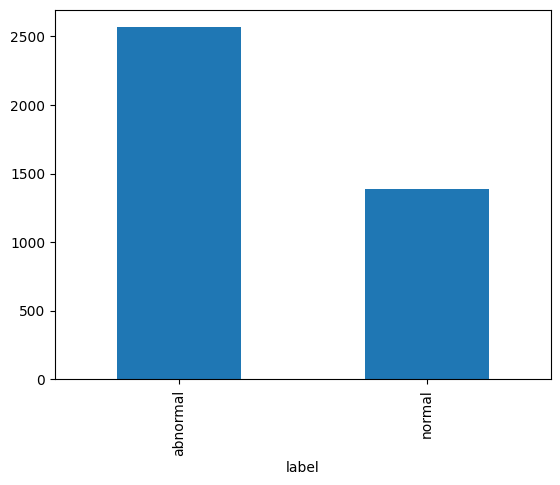

In [4]:
label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
print()
label_counts.plot.bar();

As we see in the bar graph above, there are almost twice as many abnormal reports as there are normal reports. This will be important to remember as we partition our data into training, validation, and test sets.

In fact, we'll go ahead and split off ("hold out") the test set right now to ensure our model is not exposed to it until the very end.

We'll set it up such that the our test set is 15% of our full data set and keep the relative percentage of labels the same as in our full dataset.

Test set size: 594
Abnormal: 385
Normal: 209



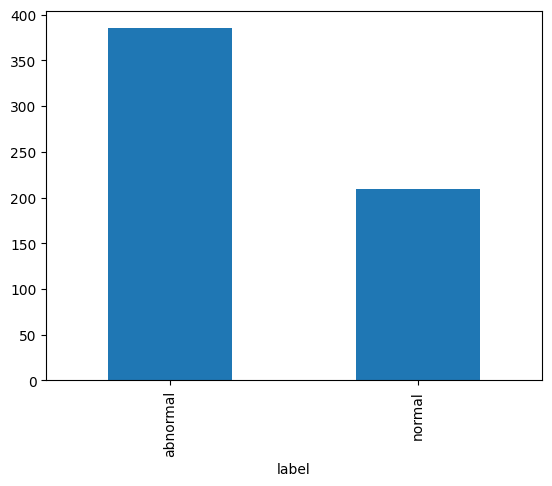

In [5]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

train_val, test_df = train_test_split(reports_df, test_size=0.15, stratify=reports_df.label.values)
print('Test set size:', test_df.shape[0])
test_counts = test_df.label.value_counts()
print('Abnormal:', test_counts['abnormal'])
print('Normal:', test_counts['normal'])
print()
test_counts.plot.bar();

# Language Modeling

The types of algorithms we use in NLP work with with numbers, not text. Therefore, we need a way to convert text into numbers. We also want a way for those numbers to contain a little more information about the text they represent. Here, we'll describe the steps in preparing our text for _language modeling_.

## Tokenization

_Tokenization_ is the process by which we split text into chunks or _tokens_. An individual token could be a sentence or phrase, a word, a part of a word, or a single character. Most often, we choose to tokenize at the word or sub-word level.

Each token is assigned a sequential integer value and the collection of token-integer pairs is called our _vocabulary_.


In [6]:
#@title **Word Tokenization**

spacy = WordTokenizer()
text = train_val.iloc[0]['full-text']
print('Original text:')
print(text)
print()
tkns = first(spacy([text]))
print('After word tokenization:')
print(coll_repr(tkns))

Original text:
The XXXX examination consists of frontal and lateral radiographs of the chest. The cardiac silhouette is not enlarged. There has been apparent interval increase in low density convexity at the left cardiophrenic XXXX. Calcified granuloma is again seen in the right upper lobe. There is no consolidation, pleural effusion or pneumothorax. Increased size of density in the left cardiophrenic XXXX. Primary differential considerations include increased size of prominent epicardial fat, pericardial mass, pleural mass or cardiac aneurysm. CT chest with contrast is recommended. These findings and recommendations were discussed XXXX. XXXX by Dr. XXXX XXXX telephone at XXXX p.m. XXXX/XXXX. Dr. XXXX<XXXX>technologist receipt of the results.

After word tokenization:
['The', 'XXXX', 'examination', 'consists', 'of', 'frontal', 'and', 'lateral', 'radiographs', 'of', 'the', 'chest', '.', 'The', 'cardiac', 'silhouette', 'is', 'not', 'enlarged', '.', 'There', 'has', 'been', 'apparent', 'in

## Added features from fast.ai

You'll notice some odd-appearing tokens in the output from the next cell. These are special tokens that indicate certain things about the text.
- `'xxbos'` indicates the beginning of the text _stream_
- `'xxmaj'` indicates that the following character was capitalized before fast.ai lowered it
- `'xxrep'` followed by `'4', 'x'` means that `'x'` is repeated 4 times...the `XXXX` in the reports is a product of the _anonymization_ process that the team who generated the dataset used

These special tokens enrich the data while reducing the vocab by eliminating redundant upper and lower case variants of individual words.

In [7]:
#@title **fast.ai Tokenization**

tkn = Tokenizer(spacy)
toks = tkn(text)
print(coll_repr(toks, 15))

(#164) ['xxbos', 'xxmaj', 'the', 'xxrep', '4', 'x', 'examination', 'consists', 'of', 'frontal', 'and', 'lateral', 'radiographs', 'of', 'the'...]


## Numericalization

After converting text to tokens, the next step is to convert each unique token to a number.

For language modeling, we should do this on all of the text that we might use for training and validation. So we'll carry this out on the combined **Findings** and **Impression** for each of our reports and tokenize the text to define our _vocabulary_. Each token in the vocabulary will be identified by a unique number.

In [8]:
txts = L(train_val['full-text'].to_list())
toks = txts.map(tkn)
num = Numericalize()
num.setup(toks)
coll_repr(num.vocab, 20)

"(#1192) ['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', '.', 'no', 'the', 'is', 'are', 'normal', ',', '4', 'x', 'of', 'and'...]"

As you can see above, we have 1,192 tokens in our vocabulary. The special tokens from `fast.ai` appear first, followed by every other token in order of decreasing frequency. By default, `fast.ai` only includes tokens that appear at least 3 times in the _corpus_ (collection of texts).

In [9]:
nums = num(toks[0][:14])
print(nums)
print(' '.join(num.vocab[i] for i in nums))

TensorText([  2,   8,  11,   5,  16,  17, 162, 314,  18, 178,  19,  89, 261,
             18])
xxbos xxmaj the xxrep 4 x examination consists of frontal and lateral radiographs of


Here, we see a subset of the numericalized tokens (top) with their corresponding word tokens (bottom) from the first report in our _corpus_.

## Embedding

While these integers map one-to-one onto our tokens, their numeric value is otherwise meaningless. To embed more information into the numeric representation of our tokens, we employ a process called _language modeling_. We can either use a pre-trained language model for this _embedding_ or we can fine-tune a language model to better model our "radiology language". This latter process is called _transfer learning_.

## Language Model Transfer Learning

> Given a string of tokenized text, a _language model_ is trained to predict the next token.

By default, `fastai.text` uses a language model pre-trained on the WikiText-103 corpus, which is a frequently used benchmark for NLP models, similar to ImageNet for image classification models.

In their 2018 ACL paper "[Universal Language Model Fine-Tuning for Text Classification](https://arxiv.org/abs/1801.06146)", Jeremy Howard and Sebastian Ruder proposed the ULM-FiT approach of fine-tuning the language model on the corpus on which a second text classification model is trained. In the paper, they demonstrated state-of-the-art performance on a commonly used text classification example using this method.

Here, we will fine-tune the language model on our radiology report text in two stages.

:::{.callout-note}
This portion of the notebook takes between 3 and 10 minutes to run.
:::

In [10]:
dls_lm = TextDataLoaders.from_df(train_val, valid_pct=0.3, seed=42, text_col='full-text', is_lm=True)
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()]).to_fp16()

# Train the final layers of the network
learn_lm.fit_one_cycle(1, 2e-2)
print("\nPart 1/2 complete.\n")

# Unfreeze and train some more
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 2e-3)
print("\nPart 2/2 complete.\n")

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.243420,2.253190,0.521906,9.518048,00:06



Part 1/2 complete.



epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.383461,2.023076,0.560477,7.561547,00:06
1,2.197973,1.785538,0.604102,5.962786,00:07
2,2.016547,1.625365,0.632902,5.080271,00:06
3,1.852749,1.529698,0.654709,4.616784,00:06
4,1.727462,1.485514,0.664200,4.417233,00:06
5,1.613133,1.435348,0.674501,4.201105,00:06
6,1.520230,1.406741,0.680834,4.082631,00:06
7,1.441349,1.394186,0.684216,4.031690,00:06
8,1.376257,1.386329,0.686632,4.000140,00:06
9,1.340578,1.385572,0.687009,3.997111,00:07



Part 2/2 complete.



We need to save this model state in a special format in order to use it for our Embedding layer in the text classification model.

We also want to use the same vocabulary that we used for the ULM-FiT procedure in our classification model.

In [11]:
torch.save(learn_lm.dls.vocab, 'vocab.pkl')
learn_lm.save_encoder('fine-tuned-enc')
print('Saved.')

Saved.


# Report Classifier Training

In the steps that follow, we will train a second model as a text classifier, using embeddings from our fine-tuned language model. We will then test the classifier on our held-out test set to see how it performs on data it hasn't seen yet.

After running through the following cells the first time, you might experiment with setting `fine_tuned_lm` to `False` or setting `training_target` to `impression` to see how your results differ with different conditions.

In [12]:
training_target = 'full-text'
validation_pct = 0.3
fine_tuned_LM = True

lm_vocab = torch.load('vocab.pkl')
dls_cls = TextDataLoaders.from_df(train_val, valid_pct=validation_pct, seed=42, text_col=training_target, label_col='label', text_vocab=lm_vocab)
dls_cls.show_batch(max_n=3)

,text,category
0,xxbos xxmaj chest xxmaj comparison : xxmaj there is a xxunk cm diameter masslike density over the lingula partial obscuration left cardiac xxrep 4 x . xxmaj there may be some ill - defined opacity in the right mid and lower lung zone . xxmaj no pleural effusion is seen . xxmaj the heart is borderline enlarged . xxmaj the aorta is dilated and tortuous . xxmaj arthritic changes of the spine are present . xxmaj pelvis and left hip xxmaj there is an xxunk and rotated fracture through the neck of the femur on the left . xxmaj no xxunk fracture is seen . xxmaj arthritic changes are present in the lower lumbar spine . xxmaj large amount of stool and xxrep 4 x obscures portions of the pelvis . xxmaj femur xxmaj the femoral images do not xxrep 4 x the area of the hip fracture . xxmaj,abnormal
1,"xxbos xxmaj chest : 2 images . xxmaj heart size is normal . xxmaj mediastinal contours are maintained . xxmaj there is a mild pectus excavatum deformity . xxmaj the lungs are clear of focal infiltrate . xxmaj there is no evidence for pleural effusion or pneumothorax . xxmaj no convincing acute bony findings . xxmaj right shoulder : 3 images . xxmaj there has been xxrep 4 x and screw fixation of the xxunk right clavicle . xxmaj the lateral most screw is fractured . xxmaj this is age - indeterminate as no prior studies are available for comparison . xxmaj otherwise , the surgical xxrep 4 x appears intact . xxmaj the humeral head is seen within the glenoid , without evidence for dislocation . xxmaj no bony fractures are seen . xxmaj the visualized right ribs appear intact . xxmaj right clavicle : 2 images . xxmaj",abnormal
2,"xxbos xxmaj the heart size and pulmonary vascularity appear within normal limits . xxmaj the lungs are free of focal airspace disease . xxmaj no pleural effusion or pneumothorax is seen . xxmaj osteopenia and xxrep 4 x deformities , degenerative changes and scoliosis are present in the thoracic spine . xxmaj calcified granuloma is present in the left upper lobe . xxmaj on xxrep 4 x xxunk of a xxrep 4 x scan xxrep 4 x xxrep 4 x / xxrep 4 x , several nodules were identified . a nodule is seen in the right middle lobe which corresponds with one of the nodules present on the previous xxup ct scan . 1 . xxmaj right middle lobe lung nodule . xxmaj corresponds to one of xxunk seen on the previous xxrep 4 x scan . xxmaj the other nodules seen on the chest xxup ct scan are",abnormal


## Iterative Training Process

So that we don't propagate too much error through the network during training, we will train the final layers first, then iteratively _unfreeze_ (i.e. make trainable) a few preceding layers and train a little more before repeating this process.

In [13]:
learn_cls = text_classifier_learner(dls_cls, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
if fine_tuned_LM: learn_cls.load_encoder('fine-tuned-enc')
learn_cls.fit_one_cycle(1, 2e-2)
print("\nPart 1/4 complete.\n")

# Unfreezing and training a little more...
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))
print("\nPart 2/4 complete.\n")

# Unfreezing and training a little more, again...
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
print("\nPart 3/4 complete.\n")

# Now let's unfreeze the whole model and finish training.
learn_cls.unfreeze()
learn_cls.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))
print("\nPart 4/4 complete.")

epoch,train_loss,valid_loss,accuracy,time
0,0.529666,0.375562,0.922619,00:05



Part 1/4 complete.



epoch,train_loss,valid_loss,accuracy,time
0,0.487774,0.255552,0.939484,00:04



Part 2/4 complete.



epoch,train_loss,valid_loss,accuracy,time
0,0.380615,0.170027,0.948413,00:05



Part 3/4 complete.



epoch,train_loss,valid_loss,accuracy,time
0,0.297941,0.143385,0.955357,00:07



Part 4/4 complete.


In [14]:
# Export fine-tuned classifier model

learn_cls.export('full-text')

## Tensorboard

Run the following cell, then hit the refresh button in the top right menu of the Tensorboard iframe that appears.

Next, look along the left hand menu for `T-SNE`. Click it and let it run for ~1,000 iterations. Then hit the "stop" button.

Now, explore the embedding space to see how radiological terms cluster in the embedding space of a language model fine-tuned on CXR reports.

![Tensorboard T-SNE Embedding Visualization](/images/tensorboard.png)

## Testing the model

Now that our model is trained, let's test it on our held-out test dataset.

We will run our report classification model on the held-out test dataset.

A report will be generated with the following information:

- __precision__: a.k.a. positive predictive value = true_positives / all_predicted_positives
- __recall__: a.k.a. sensitivity = true_positives / all_actual_positives
- __f1-score__: the harmonic mean of precision and recall
- __accuracy__: number_correct / number_reports

:::{.callout-note}
Support = number of reports used to derive the result in that row
:::


In [16]:
test_items = test_df[[training_target, 'label']].copy()
test_items.columns = ['text', 'label']
dl_test = learn_cls.dls.test_dl(test_items, with_labels=True)
interp = ClassificationInterpretation.from_learner(learn_cls, dl=dl_test)
interp.print_classification_report()

              precision    recall  f1-score   support

    abnormal       0.97      0.95      0.96       385
      normal       0.91      0.95      0.93       209

    accuracy                           0.95       594
   macro avg       0.94      0.95      0.95       594
weighted avg       0.95      0.95      0.95       594



## The confusion matrix

The _confusion matrix_ is a graphical representation of how the model performed.
In our case, it is a 2x2 table comparing model predictions to the actual label for each class (i.e. "normal" and "abnormal").

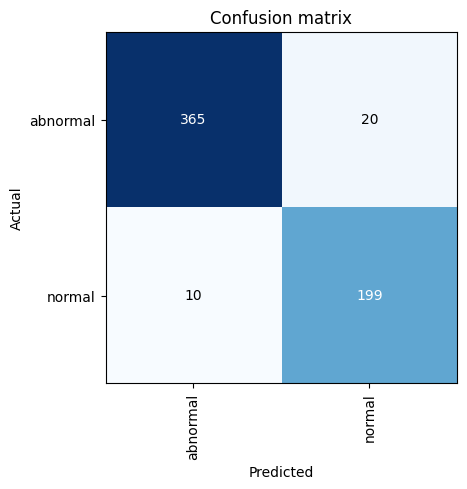

In [17]:
interp.plot_confusion_matrix()

## Analyzing the failures or "top losses"

The _loss function_ gives us a numerical value telling us how far off the model's prediction is from the actual class.
The higher the loss, the more confused our model is.

Analyzing the top losses can help you understand why your model fails when it fails.
Here, we plot the top 3 losses for our test dataset.

In [18]:
interp.plot_top_losses(3)

,input,target,predicted,probability,loss
0,"xxbos xxmaj the heart , pulmonary xxrep 4 x and mediastinum are within normal limits . xxmaj there is no pleural effusion or pneumothorax . xxmaj there is no focal air space opacity to suggest a pneumonia . xxmaj there is no pulmonary nodule identified . xxmaj there is a left humerus prosthesis xxunk demonstrated . xxmaj no acute cardiopulmonary disease . xxmaj no evidence for metastatic disease by radiographic evaluation .",normal,abnormal,0.9536540508270264,3.5140838623046875
1,xxbos xxmaj the heart size and pulmonary vascularity appear within normal limits . xxmaj lungs are free of focal airspace disease . xxmaj no pleural effusion or pneumothorax is seen . xxmaj no discrete nodules or adenopathy are noted . xxmaj degenerative changes are present in the spine . xxmaj no evidence of active disease .,normal,abnormal,0.9602826833724976,3.225968599319458
2,"xxbos xxmaj heart xxrep 4 x , mediastinum , xxrep 4 x , bony structures and lung xxrep 4 x are unremarkable . xxmaj no radiographic evidence of acute cardiopulmonary disease",abnormal,normal,0.9702249765396118,3.071622133255005


# **BONUS:** Language Model Text Generation

Just for fun, let's see how well our language model does at generating text.

Enter ~3-5 words in the `text` string to give our language model something to work with, then edit other options and run the cell.

Setting `ULMFiT` to `False` will generate predictions without our fine-tuned model.

In [19]:
text = 'Normal heart size'
words_per_sentence = 18
num_sentences = 2
ULMFiT = True

print('Generating predictions...')
if ULMFiT:
    preds = [learn_lm.predict(text, words_per_sentence, temperature=0.75) for _ in range(num_sentences)]
else:
    learn_lm_new = language_model_learner(dls_lm, AWD_LSTM)
    preds = [learn_lm_new.predict(text, words_per_sentence, temperature=0.75) for _ in range(num_sentences)]
print()
for i, pred in enumerate(preds): print(f'Sentence {i + 1}: {pred}')

Generating predictions...



Sentence 1: Normal heart size and mediastinal contours . No focal airspace consolidation . No pleural effusion or pneumothorax .
Sentence 2: Normal heart size . No pneumothorax or large pleural effusions . No focal airspace consolidation . Visualized osseous


Looks like our generated text is pretty realistic! Try it again without the pre-trained model and you'll really see how the ULM-FiT approach contributes to a better text classification model.